In [57]:
# pipenv install pandas matplotlib scipy plotly scikit-learn optuna shap ipykernel ipywidgets nbformat numpy==2.0

# Importar bibliotecas

# EDA
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Visualizações
import plotly.express as px
import plotly.graph_objects as go

# Para preparação dos dados
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, log_loss, roc_curve, roc_auc_score, f1_score, precision_score, recall_score

# Otimização de Hiperparâmetros
import optuna

### Carregar os dados

In [2]:
# Carregar o dataset
df_employees = pd.read_csv('./datasets/employee_churn.csv', parse_dates=[
  'data_contratacao',
  'data_demissao',
  'data_ultimo_feedback',
  'data_ultimo_aumento',
  'data_ultima_mudanca_cargo'
], date_format='%Y-%m-%d')

In [3]:
# Visualizar estrutura do dataset
df_employees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         2000 non-null   object        
 1   idade                      2000 non-null   int64         
 2   genero                     2000 non-null   object        
 3   estado_civil               2000 non-null   object        
 4   educacao                   2000 non-null   object        
 5   regime_trabalho            2000 non-null   object        
 6   data_contratacao           2000 non-null   datetime64[ns]
 7   data_demissao              286 non-null    datetime64[ns]
 8   tipo_demissao              286 non-null    object        
 9   cargo                      2000 non-null   object        
 10  salario_atual              2000 non-null   int64         
 11  data_ultimo_feedback       2000 non-null   datetime64[ns]
 12  data_u

In [4]:
# Visualizar primeiros registros
df_employees.head()

,id,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,salario_atual,data_ultimo_feedback,data_ultimo_aumento,data_ultima_mudanca_cargo,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn
0,EMP1564,37,F,Divorciado(a),Master,Remoto,2020-01-02,NaT,NaN,Senior Developer,10207,2024-05-09,2023-07-31,2022-11-03,9.6,True,5,1,7.0,0
1,EMP0959,45,Outro,Divorciado(a),Master,Remoto,2020-01-03,NaT,NaN,UX Designer,23921,2024-04-05,2023-09-10,2022-02-11,8.4,True,8,4,9.1,0
2,EMP0494,54,M,Viúvo(a),Technical Degree,Híbrido,2020-01-04,NaT,NaN,Tech Lead,15298,2023-06-16,2021-12-26,2021-05-10,8.5,False,9,7,1.3,0
3,EMP1231,44,M,Casado(a),Bachelor,Remoto,2020-01-05,NaT,NaN,QA Engineer,15306,2021-12-04,2022-01-01,2024-08-30,7.9,False,8,4,8.4,0
4,EMP1912,53,Outro,Viúvo(a),PhD,Presencial,2020-01-07,NaT,NaN,Senior Developer,17723,2022-03-04,2023-11-18,2024-08-08,7.5,True,5,2,8.2,0


In [5]:
# Visualizar últimos registros
df_employees.tail()

,id,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,salario_atual,data_ultimo_feedback,data_ultimo_aumento,data_ultima_mudanca_cargo,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn
1995,EMP0353,50,Outro,Viúvo(a),Bachelor,Remoto,2024-07-23,NaT,NaN,QA Engineer,7378,2024-08-21,2024-09-03,2024-08-10,9.3,True,6,3,10.0,0
1996,EMP1808,26,F,Divorciado(a),PhD,Presencial,2024-07-24,2024-10-06,Voluntária,Senior Developer,8501,2024-09-17,2024-09-17,2024-10-04,9.9,False,4,6,4.7,1
1997,EMP0503,35,F,Viúvo(a),PhD,Presencial,2024-07-24,NaT,NaN,Senior Developer,22488,2024-10-14,2024-08-15,2024-10-19,8.0,False,6,1,6.8,0
1998,EMP1266,33,F,Viúvo(a),Technical Degree,Híbrido,2024-07-25,NaT,NaN,QA Engineer,13748,2024-09-20,2024-08-07,2024-10-11,8.7,False,8,1,2.6,0
1999,EMP1815,53,F,Solteiro(a),PhD,Presencial,2024-07-25,NaT,NaN,QA Engineer,16819,2024-10-09,2024-09-11,2024-09-04,7.9,False,9,2,2.3,0


### Engenharia de Features

In [6]:
# Criar features baseadas em datas (diferença em dias)

# Calcular tempo de empresa
df_employees['tempo_empresa'] = df_employees.apply(
  lambda x: (pd.Timestamp.now() - x['data_contratacao']).days 
  if x['churn'] == 0
  else (x['data_demissao'] - x['data_contratacao']).days, axis=1
)

# Calcular tempo desde o último feedback
df_employees['dias_desde_ultimo_feedback'] = (pd.Timestamp.now() - df_employees['data_ultimo_feedback']).dt.days

# Calcular tempo desde o último aumento
df_employees['dias_desde_ultimo_aumento'] = (pd.Timestamp.now() - df_employees['data_ultimo_aumento']).dt.days

# Calcular tempo desde a última mudança de cargo
df_employees['dias_desde_ultima_mudanca_cargo'] = (pd.Timestamp.now() - df_employees['data_ultima_mudanca_cargo']).dt.days

In [7]:
# Remover Id
df_employees.drop(columns=['id'], axis=1, inplace=True)

### EDA

In [8]:
# Verificação de valores ausentes
print("Valores ausentes por coluna:")
df_employees.isnull().sum()

Valores ausentes por coluna:


idade                                 0
genero                                0
estado_civil                          0
educacao                              0
regime_trabalho                       0
data_contratacao                      0
data_demissao                      1714
tipo_demissao                      1714
cargo                                 0
salario_atual                         0
data_ultimo_feedback                  0
data_ultimo_aumento                   0
data_ultima_mudanca_cargo             0
nota_avaliacao                        0
acompanhamento_psicologo              0
qtde_projetos                         0
qtde_clientes                         0
nivel_satisfacao_gestor               0
churn                                 0
tempo_empresa                         0
dias_desde_ultimo_feedback            0
dias_desde_ultimo_aumento             0
dias_desde_ultima_mudanca_cargo       0
dtype: int64

In [9]:
# Distribuição da variável target em percentual
fig = px.bar(
  df_employees['churn'].value_counts() / len(df_employees) * 100,
  title='Fator de Churn',
  labels={'index': 'Churn', 'value': 'Percentual'},
  opacity=0.8
)

fig.update_layout(showlegend=False)
fig.show()

In [10]:
# Valores possíveis para variáveis categóricas
for col in df_employees.select_dtypes(include=['object']).columns:
  print(f'\nValores únicos em {col}:')
  print(df_employees[col].unique())


Valores únicos em genero:
['F' 'Outro' 'M']

Valores únicos em estado_civil:
['Divorciado(a)' 'Viúvo(a)' 'Casado(a)' 'Solteiro(a)']

Valores únicos em educacao:
['Master' 'Technical Degree' 'Bachelor' 'PhD']

Valores únicos em regime_trabalho:
['Remoto' 'Híbrido' 'Presencial']

Valores únicos em tipo_demissao:
[nan 'Involuntária' 'Voluntária']

Valores únicos em cargo:
['Senior Developer' 'UX Designer' 'Tech Lead' 'QA Engineer'
 'Junior Developer' 'Product Manager' 'DevOps Engineer' 'Data Scientist']


In [11]:
# Estatísticas descritivas das variáveis numéricas
df_employees.select_dtypes(include=['int64', 'float64']).describe()

,idade,salario_atual,nota_avaliacao,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn,tempo_empresa,dias_desde_ultimo_feedback,dias_desde_ultimo_aumento,dias_desde_ultima_mudanca_cargo
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000,2000.00000,2000.000000,2000.000000
mean,37.938500,14801.834500,7.997550,4.984500,3.998500,5.492450,0.14300,893.685,526.89900,540.005000,527.136500
std,9.456132,5763.451836,1.157324,2.593188,1.987076,2.609817,0.35016,492.925,395.59628,397.623967,395.911115
min,22.000000,5016.000000,6.000000,1.000000,1.000000,1.000000,0.00000,34.000,40.00000,41.000000,40.000000
25%,30.000000,9844.250000,7.000000,3.000000,2.000000,3.300000,0.00000,457.750,196.75000,202.750000,200.750000
50%,38.000000,14822.500000,8.000000,5.000000,4.000000,5.500000,0.00000,886.000,425.50000,440.000000,417.000000
75%,46.000000,19702.500000,9.000000,7.000000,6.000000,7.700000,0.00000,1315.500,766.25000,799.250000,760.000000
max,54.000000,24988.000000,10.000000,9.000000,7.000000,10.000000,1.00000,1796.000,1759.00000,1712.000000,1752.000000


In [12]:
# Boxplots para variáveis numéricas com Churn
for col in df_employees.select_dtypes(include=['int64', 'float64']).columns:
  if col != 'churn':
    fig = px.box(
      df_employees,
      x='churn',
      y=col,
      title=f'Boxplot de {col} vs Churn',
      color='churn'
    )
    fig.show()

In [13]:
# Matriz de Correlação
colunas_numericas = df_employees.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df_employees[colunas_numericas].corr()

fig = px.imshow(
  corr_matrix,
  title='Matriz de Correlação',
  color_continuous_scale='Viridis',
  zmin=-1,
  zmax=1
)

fig.update_traces(
  text=corr_matrix,
  texttemplate='%{text:.1%}',
  textfont={'size': 9}
)
fig.update_layout(
  width=1000,
  height=600,
  title_font=dict(size=14),
  font=dict(size=10)
)

fig.show()

In [14]:
# Matriz de dispersão
fig = px.scatter_matrix(
  df_employees,
  dimensions=colunas_numericas,
  color='churn',
  title='Matriz de Dispersão'
)

fig.update_layout(
  width=1200,
  height=1000,
  title_font=dict(size=14),
  font=dict(size=9)
)

fig.show()

In [15]:
# Teste de hipótese para variáveis categóricas vs Churn
colunas_categoricas = df_employees.select_dtypes(include=['object']).columns
for col in colunas_categoricas:
  contingency_table = pd.crosstab(df_employees['churn'], df_employees[col])
  chi2, p_value, dof, expected = chi2_contingency(contingency_table)
  print(f'\nTeste Chi-quadrado para {col} vs Churn:')
  print(f'p-valor: {p_value}')
  if p_value <= 0.05:
    print(f'As variáveis {col} e Churn não são independentes')
  else:
    print(f'As variáveis {col} e Churn são independentes')


Teste Chi-quadrado para genero vs Churn:
p-valor: 0.6391382063144609
As variáveis genero e Churn são independentes

Teste Chi-quadrado para estado_civil vs Churn:
p-valor: 0.8332629331272039
As variáveis estado_civil e Churn são independentes

Teste Chi-quadrado para educacao vs Churn:
p-valor: 0.20475149121388256
As variáveis educacao e Churn são independentes

Teste Chi-quadrado para regime_trabalho vs Churn:
p-valor: 0.9751275918764937
As variáveis regime_trabalho e Churn são independentes

Teste Chi-quadrado para tipo_demissao vs Churn:
p-valor: 1.0
As variáveis tipo_demissao e Churn são independentes

Teste Chi-quadrado para cargo vs Churn:
p-valor: 0.4586024122014404
As variáveis cargo e Churn são independentes


In [16]:
# Gráficos de barras para variáveis categóricas vs Churn
for col in colunas_categoricas:
  fig = px.histogram(
    df_employees,
    x=col,
    color='churn',
    barmode='group',
    title=f'Distribuição de {col} por Churn'
  )

  fig.show()

### Preparação dos dados

In [17]:
# Separar features e target

# Criar lista de colunas do tipo datetime
colunas_data = list(df_employees.select_dtypes(include=['datetime64']).columns)

# X e y
X = df_employees.drop(columns=['churn', 'tipo_demissao'] + colunas_data, axis=1)
y = df_employees['churn']

In [18]:
# Criar preprocessador

# Lista de Colunas por Tipo
features_numericas = X.select_dtypes(include=['int64', 'float64']).columns
features_categoricas = X.select_dtypes(include=['object']).columns

# Preprocessador
preprocessor = ColumnTransformer(
  transformers=[
    ('num', StandardScaler(), features_numericas),
    ('cat', OneHotEncoder(handle_unknown='ignore'), features_categoricas)
  ]
)

In [19]:
# Dividir os dados entre Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=51, shuffle=True)

# Aplicar o Column Transformer
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [20]:
# Mostrar os conjuntos
print(X_train.shape)
print(X_test.shape)

(1000, 32)
(1000, 32)


### Treinamento do Modelo - Baseline

In [21]:
# Criar o modelo de RandomForest
rf_model = RandomForestClassifier(
  n_estimators=100,
  max_depth=20,
  min_samples_split=2,
  min_samples_leaf=1,
  random_state=51,
  max_features='sqrt',
  class_weight='balanced'
)

In [22]:
# Treinar o modelo
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20, random_state=51)

### Análise dos Resultados - Baseline

In [23]:
# Fazer predições (classificações - 0 ou 1)
y_pred = rf_model.predict(X_test)

In [24]:
# Mostrar y_pred
y_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [25]:
# Retornar as probabilidades das previsões
y_pred_proba = rf_model.predict_proba(X_test)

In [26]:
# Mostrar Probabilidades
y_pred_proba

array([[0.96, 0.04],
       [0.97, 0.03],
       [0.94, 0.06],
       ...,
       [0.97, 0.03],
       [0.37, 0.63],
       [0.58, 0.42]])

In [27]:
# Avaliação do Modelo
print("Relatório de Classificação")
print(classification_report(y_test, y_pred))

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       855
           1       1.00      0.34      0.51       145

    accuracy                           0.91      1000
   macro avg       0.95      0.67      0.73      1000
weighted avg       0.91      0.91      0.88      1000



In [28]:
# Retornar os valores da curva ROC - TPR vs. FPR e Threshold (Pontos de Corte)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

In [29]:
# Calcular AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

In [30]:
# Plotar a Curva ROC com o valor do AUC
fig = px.area(
  x=fpr,
  y=tpr,
  title=f'ROC Curve (AUC={roc_auc:.4f})',
  labels=dict(x='False Positive Rate', y='True Positive Rate'),
  width=700,
  height=500
)

fig.add_shape(
  type='line',
  line=dict(dash='dash'),
  x0=0,
  x1=1,
  y0=0,
  y1=1
)

fig.update_yaxes(
  scaleanchor='x',
  scaleratio=1
)

fig.update_xaxes(
  constrain='domain'
)

fig.show()

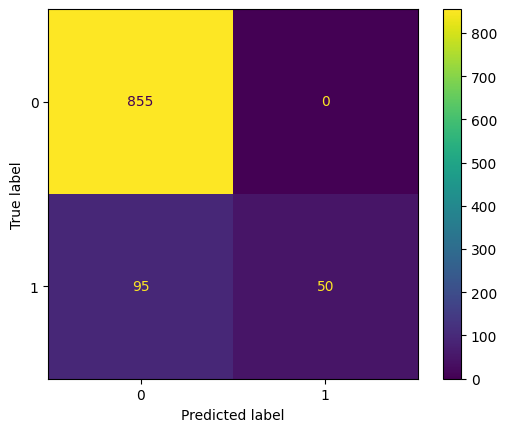

In [31]:
# Mostrar a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(conf_matrix)
fig.plot()

In [32]:
# Calcular log loss
print(f'Log Loss: {log_loss(y_test, y_pred_proba):.4f}')

Log Loss: 0.2478


### Treinar Modelo com Validação Cruzada e Tuning de Hiperparâmetros

In [33]:
# Criar um dicionário com os valores do hiperparâmetros a serem testados
param_grid = {
  'n_estimators': [50, 100, 200],
  'max_depth': [None, 10, 20, 30],
  'min_samples_split': [2, 5, 10, 20],
  'min_samples_leaf': [1, 2, 5, 10]
}

In [34]:
# Configurar o GridSearchCV com 5 folds (com StratifiedKFold) e usando Recall como métrica de validação
rf_model_cv = RandomForestClassifier(
  class_weight='balanced',
  max_features='sqrt',
  random_state=51
)

kfolds = StratifiedKFold(
  n_splits=5,
  shuffle=True,
  random_state=51
)

grid_search = GridSearchCV(
  rf_model_cv,
  param_grid,
  cv=kfolds,
  scoring='recall',
  verbose=2
)

In [35]:
# Treinar o modelo usando cross-validation para buscar melhores hiperparâmetros
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_de

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=51, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=51),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [50, 100, 200]},
             scoring='recall', verbose=2)

Usando o conceito de Cross Validation, nós trabalhamos na verdade com conjunto de Treino + Validação + Teste

X_train -> cross_validate -> 4 partições para treino + 1 validação

Gera o melhor modelo e validamos com X_teste (50%)

### Análise de Resultado - GridSearchCV

In [36]:
# Retornar o melhor modelo
best_model = grid_search.best_estimator_

In [37]:
# Retornar os melhores hiperparâmetros
best_params = grid_search.best_params_

In [38]:
# Apresentar melhores hiperparâmetros
best_params

{'max_depth': 10,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 200}

In [39]:
# Retornar a melhor métrica
best_score = grid_search.best_score_

In [40]:
# Apresentar a melhor métrica
best_score

np.float64(0.5679802955665024)

In [41]:
# Fazer predições (classificações - 0 ou 1)
y_pred = best_model.predict(X_test)

In [42]:
# Mostrar y_pred
y_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [43]:
# Retornar as probabilidades das previsões
y_pred_proba = best_model.predict_proba(X_test)

In [44]:
# Mostrar Probabilidades
y_pred_proba

array([[0.89398804, 0.10601196],
       [0.8828341 , 0.1171659 ],
       [0.7591692 , 0.2408308 ],
       ...,
       [0.81263329, 0.18736671],
       [0.28712679, 0.71287321],
       [0.37139817, 0.62860183]])

In [45]:
# Avaliação do Modelo
print("Relatório de Classificação")
print(classification_report(y_test, y_pred))

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       855
           1       0.98      0.54      0.70       145

    accuracy                           0.93      1000
   macro avg       0.95      0.77      0.83      1000
weighted avg       0.94      0.93      0.92      1000



In [46]:
# Retornar os valores da curva ROC - TPR vs. FPR e Threshold (Pontos de Corte)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

In [47]:
# Calcular AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

In [48]:
# Plotar a Curva ROC com o valor do AUC
fig = px.area(
  x=fpr,
  y=tpr,
  title=f'ROC Curve (AUC={roc_auc:.4f})',
  labels=dict(x='False Positive Rate', y='True Positive Rate'),
  width=700,
  height=500
)

fig.add_shape(
  type='line',
  line=dict(dash='dash'),
  x0=0,
  x1=1,
  y0=0,
  y1=1
)

fig.update_yaxes(
  scaleanchor='x',
  scaleratio=1
)

fig.update_xaxes(
  constrain='domain'
)

fig.show()

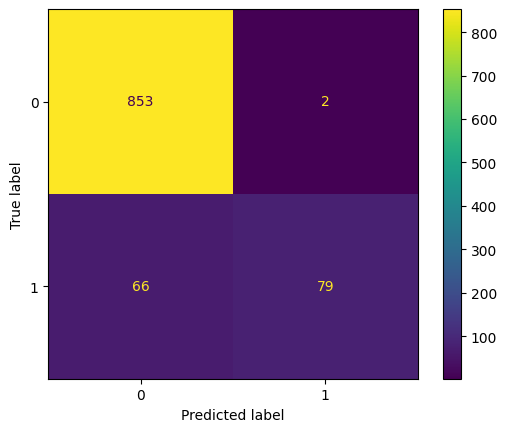

In [49]:
# Mostrar a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(conf_matrix)
fig.plot()

In [50]:
# Calcular log loss
print(f'Log Loss: {log_loss(y_test, y_pred_proba):.4f}')

Log Loss: 0.3449


### Ajustar Threshold

In [52]:
# Criar uma lista de thresholds para testar
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

# Lista para armazenar métrica
recalls = []

# Calcular as métricas para cada threshold
for threshold in thresholds:
  # Fazer predições com o threshold
  y_pred_threshold = (y_pred_proba[:, 1] >= threshold).astype(int)

  # Calcular métrica
  recall = recall_score(y_test, y_pred_threshold)

  # Inserir métrica na lista
  recalls.append(recall)

In [53]:
# Criar Dataframe com os resultados
df_thresholds = pd.DataFrame({
  'Threshold': thresholds,
  'Recall': recalls
})

In [54]:
df_thresholds.head()

,Threshold,Recall
0,0.3,0.813793
1,0.4,0.717241
2,0.5,0.544828
3,0.6,0.393103
4,0.7,0.241379


In [56]:
# Encontrar o threshold com melhor recall
melhor_threshold = df_thresholds.loc[df_thresholds['Recall'].idxmax()]

print(f'Maior Threshold: {melhor_threshold['Threshold']:.2f}')
print(f'Maior Recall: {melhor_threshold['Recall']:.4f}')

Maior Threshold: 0.30
Maior Recall: 0.8138


In [58]:
# Plotar um gráfico com Threshold
fig = go.Figure()

fig.add_trace(
  go.Scatter(
    x=thresholds,
    y=recalls,
    name='Recall',
    line=dict(color='blue')
  )
)

fig.update_layout(
  title='Recall por Threshold',
  xaxis_title='Threshold',
  yaxis_title='Recall Score',
  width=800,
  height=500
)

fig.show()

### Análise de Métricas com Threshold

In [59]:
# Fazer predições
y_pred = (y_pred_proba[:, 1] >= melhor_threshold['Threshold']).astype(int)

In [60]:
# Avaliação do Modelo
print("Relatório de Classificação")
print(classification_report(y_test, y_pred))

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.96      0.78      0.86       855
           1       0.38      0.81      0.52       145

    accuracy                           0.78      1000
   macro avg       0.67      0.80      0.69      1000
weighted avg       0.88      0.78      0.81      1000



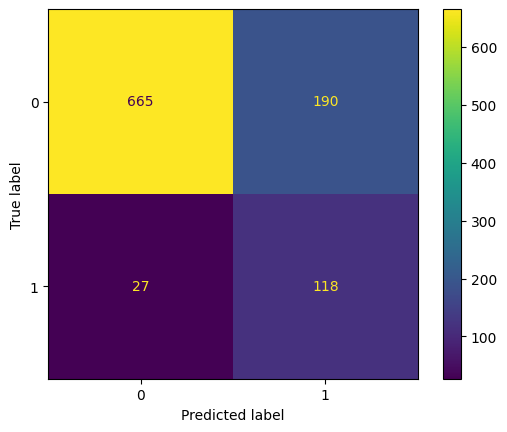

In [61]:
# Mostrar a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(conf_matrix)
fig.plot()